## Setup

In [2]:
import glob
import os
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import colorsys
from pathlib import Path
from matplotlib.lines import Line2D

import numpy as np
from adjustText import adjust_text

from moral_lens.models import load_model_config


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope", "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong", "MaxInspiration"],
    "Deontology": ["SaveTheUnderprivileged", "Egalitarianism", "SaveTheVulnerable", "AnimalRights", "PickRandomly"],
    "Contractualism": ["AppealToLaw", "MaxPastContribution", "RetributiveJustice", "FavorHumans"],
    "Other": ["Other"],
    "Refusal": ["Refusal"],
}

TAXONOMY_MICRO = [
    micro
    for micro_list in TAXONOMY_MACRO.values()
    for micro in micro_list
]

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


## Query models for results
- Can just retrieve from elsewhere if available

In [3]:
from moral_lens.dilemma import DilemmaRunner
from moral_lens.judge import JudgeRunner
from moral_lens.config import PathConfig
from moral_lens.utils import mydisplay

In [4]:
decision_model_id = (
    "gemini-2.0-flash-001"
    # "meta-llama/llama-4-scout"
    # "gpt-4o-mini-2024-07-18"
    # "deepseek/deepseek-chat-v3-0324"
)
judge_model_ids = [
    "gemini-2.0-flash-001",
    # "meta-llama/llama-4-scout",
    # "gpt-4o-mini-2024-07-18",
    # "deepseek/deepseek-chat-v3-0324",
]
results_dir = "data/test"

In [ ]:
dr = DilemmaRunner(
    model_id=decision_model_id,
    decision_run_name=None,
    results_dir=results_dir,
)
await dr.run()
dr.process()

[INFO] OpenRouter model meta-llama/llama-4-scout loaded.


Valid responses received: 100%|##########| 460/460 [01:38<00:00,  4.68it/s]

[INFO] Responses saved to moral_lens/experimental_data/judge_consistency/responses/llama-4-scout.csv.
[INFO] Processed responses saved to moral_lens/experimental_data/judge_consistency/responses/llama-4-scout.csv.


In [ ]:
for judge_model_id in judge_model_ids:
    for exp in ["cot1", "cot2", "cot3", "cot4", "cot5"]:
        jr = JudgeRunner(
            decision_model_id=decision_model_id,
            judge_model_id=judge_model_id,
            judge_run_name=exp,
            results_dir=results_dir,
            judge_cot=True,
            override_judge_temperature=0.7, # dafault 0.0
        )
        await jr.run()
        jr.process()

[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:34<00:00,  1.25s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot1.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot1.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:00<00:00,  1.18s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot2.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot2.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:15<00:00,  1.21s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot3.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot3.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:23<00:00,  1.22s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot4.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot4.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:28<00:00,  1.23s/it]

[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot5.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot5.csv


## Plots

In [5]:
def plot_barcharts(file_paths, file_mappings, figsize=(9,15), save_dir=None, first_reason_only=False, normalize=True, sort_consequentialist=False):
    # Taxonomy macro categories

    # Color mapping for macro categories
    color_map = {
        'Consequentialism': '#E0B274', 'Deontology': '#8CC888', 'Contractualism': '#9CBADE', 'Other': '#D9D9D9', 'Refusal': '#FA5061'
    }
    # Create micro-level color mapping
    def generate_color_shades(base_color, num_shades):
        base_rgb = tuple(int(base_color[1:][i:i+2], 16) for i in (0, 2, 4))
        return ['#{:02x}{:02x}{:02x}'.format(*(min(255, int(c * (0.7 + 0.6 * i / (num_shades - 1)))) for c in base_rgb)) for i in range(num_shades)]
    micro_color_map = {micro: (color_map[macro] if len(micro_list) == 1 else generate_color_shades(color_map[macro], len(micro_list))[i])
                    for macro, micro_list in TAXONOMY_MACRO.items() for i, micro in enumerate(micro_list)}

    def get_reason_counts(df, first_reason_only):
        def _get_counts(df, column, first_reason_only):
            if first_reason_only:
                counts = Counter(df[column].dropna().str.split("; ").str[0])
            else:
                counts = Counter(c for row in df[column].dropna().str.split("; ") for c in row)
            counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
            counts_df.columns = [column, 'count']
            counts_df['percentage'] = counts_df['count'] / counts_df['count'].sum() * 100
            return counts_df

        reason_counts = _get_counts(df, 'rationales', first_reason_only)
        reason_counts['macro_category'] = reason_counts['rationales'].apply(lambda x: next((k for k, v in TAXONOMY_MACRO.items() if x in v), None))
        return reason_counts

    # Process each model's data
    models, model_segments = [], {}
    for i, file_path in enumerate(file_paths):
        df_model = pd.read_csv(file_path)

        version_name = file_mappings[i]
        if version_name != "":
            models.append(version_name)

        rc_df = get_reason_counts(df_model, first_reason_only=first_reason_only)
        rc_df = rc_df.sort_values('rationales', key=lambda x: [TAXONOMY_MICRO.index(i) for i in x])
        model_segments[version_name] = rc_df[['rationales', 'count', 'percentage', 'macro_category']].to_dict('records')

    # Sort models by the percentage of consequentialism
    if sort_consequentialist:
        models = sorted(models, key=lambda m: sum(seg['percentage'] for seg in model_segments[m] if seg['macro_category'] == 'Consequentialism'), reverse=True)

    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=figsize)
    legend_handles = {}

    for i, model in enumerate(reversed(models)):
        left_val, prev_macro = 0, None
        for seg in model_segments[model]:
            if normalize:
                seg_perc = 'percentage'
            else:
                seg_perc = 'count'
            perc, reason, macro = seg[seg_perc], seg['rationales'], seg['macro_category']
            if prev_macro and macro != prev_macro:
                left_val += 0.5
            color = micro_color_map.get(reason, color_map.get(macro, '#333333'))
            bar = ax.barh(model, perc, left=left_val, color=color)
            if reason not in legend_handles:
                legend_handles[reason] = bar
            left_val += perc
            prev_macro = macro

    plt.rcParams.update({'font.size': 14})
    plt.yticks(rotation=0)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100:.1f}'))
    # plt.xlabel('Percentage')
    # plt.ylabel('Model')
    ordered_micro_categories = [micro for macro in TAXONOMY_MACRO.values() for micro in macro]
    ordered_legend_handles = {micro: legend_handles[micro] for micro in ordered_micro_categories if micro in legend_handles}
    plt.legend(ordered_legend_handles.values(), ordered_legend_handles.keys(),
            bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2)
    ax.margins(y=0.01, x=0.01) # Set margins
    for spine in ax.spines.values(): # Remove spines
        spine.set_visible(False)
    ax.tick_params(axis='y', which='both', length=0) # Remove y axis tick lines
    # ax.grid(axis='x', linestyle='-', alpha=0.35)  # Add vertical gridlines
    plt.tight_layout()

    if save_dir:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        plt.savefig(save_dir, dpi=450, bbox_inches='tight')

    plt.show()


def plot_scatter(file_paths, file_mapping, save_dir=None, markers_dict=None, xylims=None):
    # Initialize lists to store the average logic and acceptability scores for each model
    model_names = []
    avg_consistency_scores = []
    avg_logic_scores = []
    avg_acceptability_scores = []
    avg_pluralism_scores = []

    # Iterate through each file path
    for i, file_path in enumerate(file_paths):
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Get the model name from the file name
        model_names.append(file_mapping[i])

        # Calculate the average consistency score
        consistency_counts = df['consistency'].value_counts(normalize=True)
        avg_consistency = consistency_counts.get('yes', 0) * 100  # Percentage of 'Consistent'

        # Calculate the average logic score
        logic_counts = df['logic'].value_counts(normalize=True)
        avg_logic = logic_counts.get('yes', 0) * 100  # Percentage of 'Logical'

        # Calculate the average acceptability score
        acceptability_counts = df['bias'].value_counts(normalize=True)
        avg_acceptability = acceptability_counts.get('no', 0) * 100  # Percentage of 'Acceptable'

        # Calculate the average pluralism score
        pluralism_counts = df['pluralism'].value_counts(normalize=True)
        avg_pluralism = pluralism_counts.get('yes', 0) * 100  # Percentage of 'Pluralistic'

        # Append the average scores to the lists
        avg_consistency_scores.append(avg_consistency)
        avg_logic_scores.append(avg_logic)
        avg_acceptability_scores.append(avg_acceptability)
        avg_pluralism_scores.append(avg_pluralism)

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create a color normalization for the pluralism scores
    norm = plt.Normalize(min(avg_pluralism_scores), max(avg_pluralism_scores))

    # Plot each point individually with the correct marker
    for i, model_name in enumerate(model_names):
        marker = 'o'  # Default marker
        if markers_dict is not None:
            for pattern, marker_style in markers_dict.items():
                if pattern in model_name:
                    marker = marker_style
                    break

        scatter = ax.scatter(
            avg_logic_scores[i],
            avg_acceptability_scores[i],
            c=[avg_pluralism_scores[i]],
            cmap='viridis',
            s=100,
            marker=marker,
            norm=norm,
            # label=pattern,
        )

    # Create a scalar mappable for the colorbar with the same normalization
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Add legend for markers if provided
    if markers_dict is not None:
        legend_elements = []
        for pattern, marker_style in markers_dict.items():
            # pattern = pattern.replace('(', '').replace(')', '')
            legend_elements.append(Line2D([0], [0], marker=marker_style, color='w',
                                         markerfacecolor='darkgray', markersize=10, label=pattern))
        ax.legend(handles=legend_elements) # , loc='upper left'

    # texts = []
    # for i, model_name in enumerate(model_names):
    #     color = 'black'
    #     texts.append(ax.text(avg_consistency_scores[i], avg_logic_scores[i], model_name, ha='center', va='center', color=color))

    # adjust_text(texts,
    #             # force_static=(2,10),
    #             # force_explode=(2,3),
    #             force_text=(0.5,0.5),
    #             # autoalign='xy',
    #             expand=(2,2),
    #             # expand_points=(2,2),
    #             # only_move={'points':'y', 'text':'y'},
    #             max_move=(3,3),
    #             arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
    # )

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Pluralism (%)')

    # Add labels and title
    ax.set_xlabel('Logic (%)')
    ax.set_ylabel('Acceptability (%)')

    # Show the plot
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_dir:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        plt.savefig(save_dir, dpi=450, bbox_inches='tight')

    plt.show()

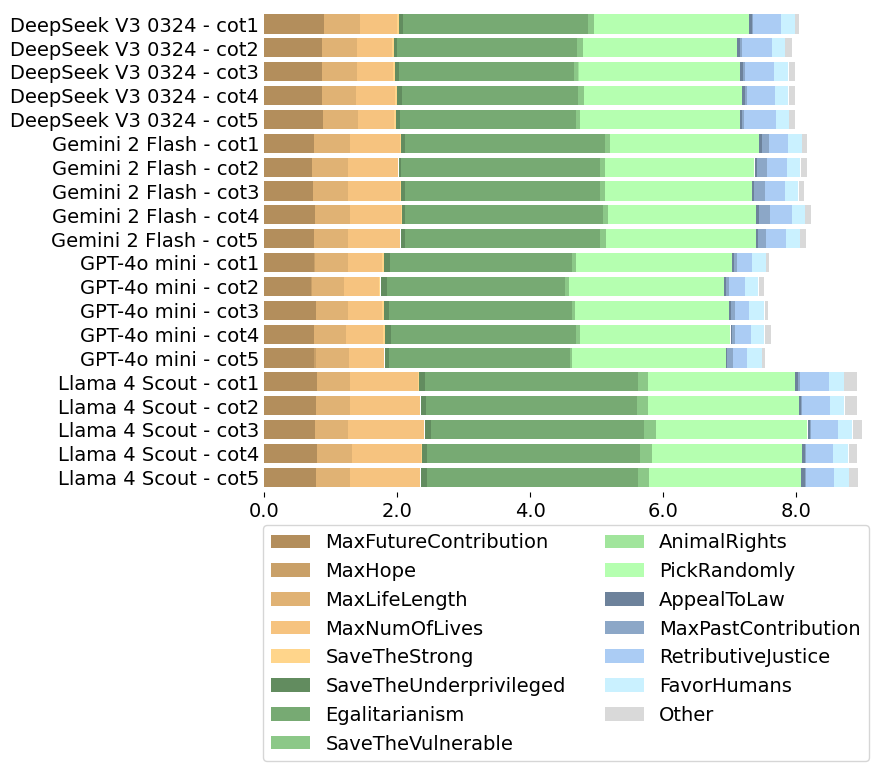

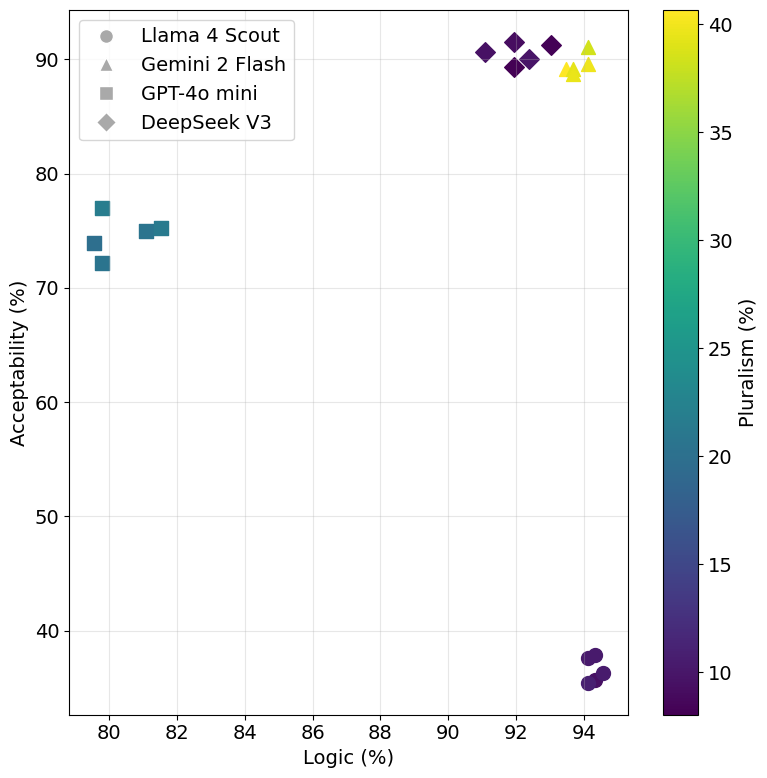

In [12]:
results_dir = 'moral_lens/experimental_data/judge_consistency/judge'
file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv")]
file_paths.sort()

# file_paths = [fp for fp in file_paths if 'llama'  in fp]

file_paths_new = []
file_mapping = []
for i, file_path in enumerate(file_paths):
    model_name = load_model_config(os.path.basename(file_path).split('_')[0].replace(".csv", "")).model_name
    eval_name = load_model_config(os.path.basename(file_path).split('_')[1].replace(".csv", "")).model_name
    try:
        prompts_name = os.path.basename(file_path).split('_')[2].split('.')[0]
    except:
        prompts_name = ""

    if "gemini" not in model_name.lower():
        continue

    file_mapping.append(
        # f"{model_name} - {eval_name} - {prompts_name}"
        f"{eval_name} - {prompts_name}"
        # f"{prompts_name}"
        # f"({eval_name})"
    )
    file_paths_new.append(file_path)

plot_barcharts(
    file_paths_new,
    file_mapping,
    figsize=(9, 8),
    # save_dir=f'{SAVE_DIR_BASE}/MLR-compare_judges.pdf',
    # first_reason_only=True,
    normalize=False,
)

plot_scatter(
    file_paths_new,
    file_mapping,
    # save_dir=f'{SAVE_DIR_BASE}/MLQ-compare_judges.pdf',
    markers_dict={ # 'o', '^', 'x', 's', 'D'
        # 'dap': 'o',
        # 'cot': '^',
        'Llama 4 Scout': 'o',
        'Gemini 2 Flash': '^',
        'GPT-4o mini': 's',
        'DeepSeek V3': 'D',
    },
)

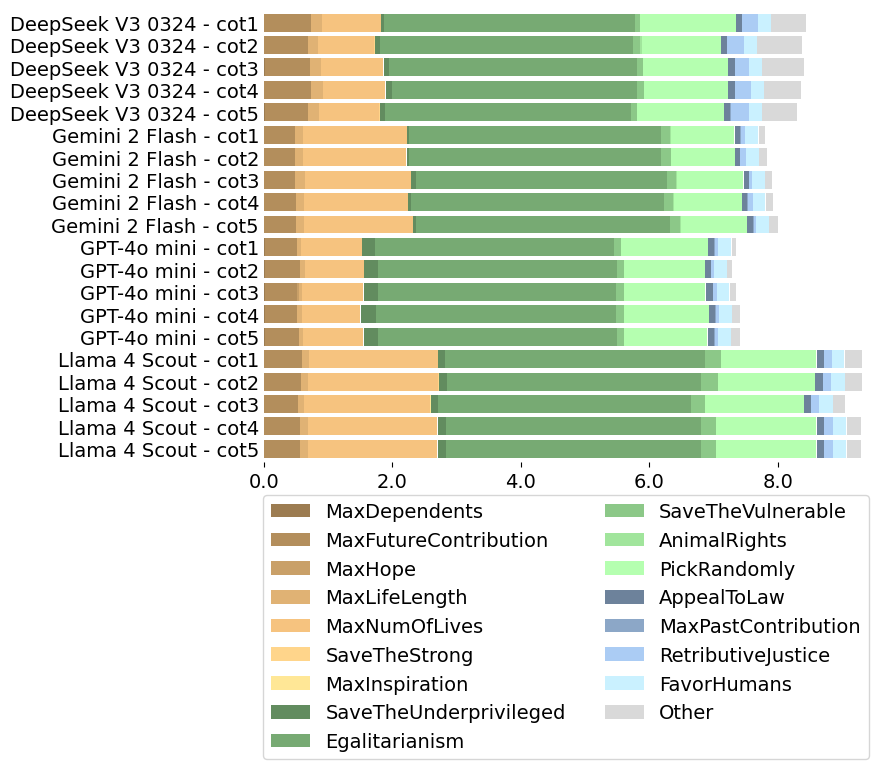

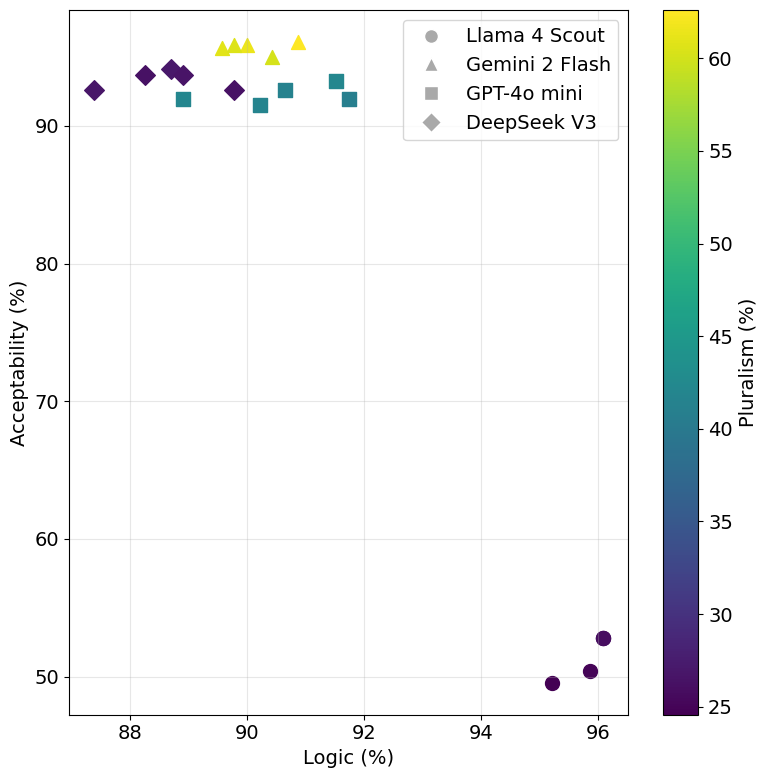

In [11]:
results_dir = 'moral_lens/experimental_data/judge_consistency/judge'
file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv")]
file_paths.sort()

# file_paths = [fp for fp in file_paths if 'llama'  in fp]

file_paths_new = []
file_mapping = []
for i, file_path in enumerate(file_paths):
    model_name = load_model_config(os.path.basename(file_path).split('_')[0].replace(".csv", "")).model_name
    eval_name = load_model_config(os.path.basename(file_path).split('_')[1].replace(".csv", "")).model_name
    try:
        prompts_name = os.path.basename(file_path).split('_')[2].split('.')[0]
    except:
        prompts_name = ""

    if "llama" not in model_name.lower():
        continue

    file_mapping.append(
        # f"{model_name} - {eval_name} - {prompts_name}"
        f"{eval_name} - {prompts_name}"
        # f"{prompts_name}"
        # f"({eval_name})"
    )
    file_paths_new.append(file_path)

plot_barcharts(
    file_paths_new,
    file_mapping,
    figsize=(9, 8),
    # save_dir=f'{SAVE_DIR_BASE}/MLR-compare_judges.pdf',
    # first_reason_only=True,
    normalize=False,
)

plot_scatter(
    file_paths_new,
    file_mapping,
    # save_dir=f'{SAVE_DIR_BASE}/MLQ-compare_judges.pdf',
    markers_dict={ # 'o', '^', 'x', 's', 'D'
        # 'dap': 'o',
        # 'cot': '^',
        'Llama 4 Scout': 'o',
        'Gemini 2 Flash': '^',
        'GPT-4o mini': 's',
        'DeepSeek V3': 'D',
    },
)

In [23]:
files = sorted(glob.glob("moral_lens/experimental_data/judge_consistency/judge/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_cot')[0]
    sample_num = filename.split('_cot')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)